#### Import libraries

In [1]:
import pandas as pd
import math
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import pmdarima as pm
from pmdarima import auto_arima

import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import plotly.io as pio
pio.renderers.default = "svg"

### Load Data

In [2]:
# Input path and filename
path = '../5. Master_thesis/Datasets/Output_files/'

# Load files into a pandas dataframes
file = path + '2.xlsx'
df = pd.concat(pd.read_excel(file, sheet_name=None), ignore_index=True)

# Set index
df = df.set_index("Date")   

In [3]:
# Dependant variable
dep_var = 'Orders'     

In [4]:
df

,Orders,CCI,CPI,Unemployment_rate,Long_term_interest_rates,Avg_Fuel_Price,TIV,Orders_rolled_detrended,TIV_rolled_detrended,Orders_lagged_12m
Date,,,,,,,,,,
2007-01-01,998,101.06670,2.302302,7.2,4.050000,1.120000,18851,70.833333,5547.500000,1124
2007-02-01,638,100.98060,2.184707,7.2,4.080000,1.133333,11852,-252.416667,-1368.750000,1079
2007-03-01,649,100.94160,2.574257,7.1,3.980000,1.183333,14386,-194.666667,1230.000000,1210
2007-04-01,753,100.98700,2.561576,6.5,4.200000,1.203333,13761,-57.833333,580.916667,1147
2007-05-01,856,100.99110,2.362205,6.6,4.330000,1.236667,14917,57.250000,1870.166667,1001
...,...,...,...,...,...,...,...,...,...,...
2022-08-01,254,94.58021,7.616082,7.2,1.624904,2.153333,8163,-0.916667,369.500000,256
2022-09-01,228,94.10754,8.119296,7.3,2.420836,2.133333,7867,-24.333333,50.750000,259
2022-10-01,188,93.96142,8.310766,6.4,2.894486,2.136667,7132,-65.166667,-648.916667,178


### Split Data

In [5]:
steps = 36  # 36 months of testing
train = df[:-steps]
test  = df[-steps:]

start=len(train)
end=len(train)+len(test)-1

print(f"Dataset length : (n={len(df)})")
print(f"Train dates    : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates     : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

Dataset length : (n=192)
Train dates    : 2007-01-01 00:00:00 --- 2019-12-01 00:00:00  (n=156)
Test dates     : 2020-01-01 00:00:00 --- 2022-12-01 00:00:00  (n=36)


### Scoring function

In [6]:
metrics = pd.DataFrame()

# Accuracy metrics
def forecast_accuracy(model_name, y_true, y_pred, print_metrics: bool, plot_results: bool):
    
    mae = np.mean(np.abs(y_pred - y_true))                                    # MAE
    mse = mean_squared_error(y_true, y_pred)                                  # MSE (Mean Squared Error)
    rmse = math.sqrt(mse)                                                     # RMSE (Root Mean Squared Error)    
    r2 = r2_score(y_true, y_pred)                                             # R2 (R-squared - Coeficient of determination)      
    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true)*100)                # MAPE        
    accuracy = 100 - mape                                                     # Accuracy

    # Append metrics for summary
    metrics[model_name] = [mae, mse, rmse, r2, mape, accuracy]
    metrics.index = ['Mean Absolute Error', 
                    'Mean Squared Error', 
                    'Root Mean Squared Error',
                    'R^2',
                    'Mean Absolute Percentage Error',
                    'Accuracy']       

    # Print metrics  
    if print_metrics:
 
        print(model_name, 'Model Performance:')                             # Model name
        print('Mean Absolute Error: {:0.2f}.'.format(mae))                  # MAE
        print('Mean Squared Error: {:0.2f}.'.format(mse))                   # MSE
        print('Root Mean Squared Error: {:0.2f}.'.format(rmse))             # RMSE  
        print('R^2 Score = {:0.2f}.'.format(r2))                            # R2
        print('Mean Absolute Percentage Error: {:0.2f}%.'.format(mape))     # MAPE 
        print('Accuracy = {:0.2f}%.'.format(accuracy))                      # Accuracy                    
    
    # Plot Actual values vs predicted values
    if plot_results:
        
        df = pd.DataFrame(y_true)

        fig= make_subplots(rows=2, cols=1)
        
        fig.add_trace(go.Scatter(dict(x=df.index, y=y_true, mode='lines', name= 'Actual'), legendgroup="Preds"), row=1, col=1)
        fig.add_trace(go.Scatter(dict(x=df.index, y=y_pred, mode='lines', name= 'Predicted'), legendgroup="Preds"), row=1, col=1)
        
        fig.add_trace(go.Scatter(dict(x=train.index, y=train[dep_var], mode='lines', name= 'Train'), legendgroup="Full"), row=2, col=1)
        fig.add_trace(go.Scatter(dict(x=test.index, y=test[dep_var], mode='lines', name= 'Test'), legendgroup="Full"), row=2, col=1)
        fig.add_trace(go.Scatter(dict(x=test.index, y=y_pred, mode='lines', name= 'Forecast'), legendgroup="Full"), row=2, col=1)

        fig.update_layout(height=600, width=1000, title_text=model_name + " Predictions")    

        fig.show()  

                    

### Modeling

#### Simple Exponential Smoothing

C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



Simple Exponential Smoothing Model Performance:
Mean Absolute Error: 173.87.
Mean Squared Error: 37634.81.
Root Mean Squared Error: 194.00.
R^2 Score = -2.93.
Mean Absolute Percentage Error: 76.33%.
Accuracy = 23.67%.


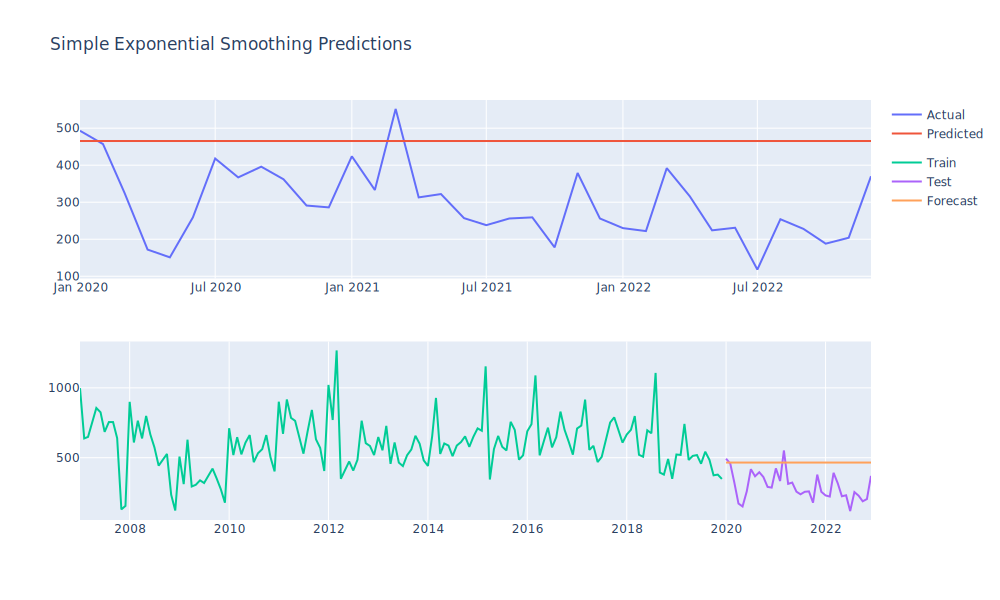

In [7]:
model_name='Simple Exponential Smoothing'
span = 12
alpha = 2/(span+1)

# Train
model = SimpleExpSmoothing(train[dep_var]).fit(smoothing_level=alpha,optimized=False)

# Predict
predictions = model.predict(start=start, end=end)

# Forecast accuracy
forecast_accuracy(model_name, test[dep_var], predictions, True, True)

#### Double Explonential Smoothing

Double Exponential Smoothing Model Performance:
Mean Absolute Error: 72.77.
Mean Squared Error: 9065.48.
Root Mean Squared Error: 95.21.
R^2 Score = 0.05.
Mean Absolute Percentage Error: 30.41%.
Accuracy = 69.59%.


C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



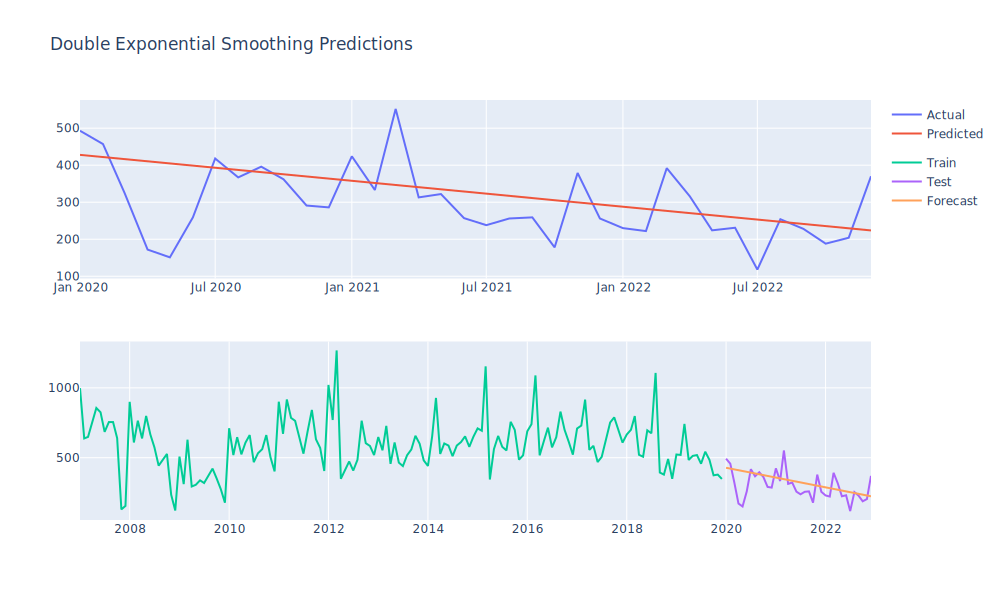

In [8]:
model_name='Double Exponential Smoothing'

# Train
model = ExponentialSmoothing(train[dep_var],trend='add',seasonal_periods=12).fit()
# Predict
predictions = model.predict(start=start, end=end)

# Forecast accuracy
forecast_accuracy(model_name, test[dep_var], predictions, True, True)

#### Triple Exponential Smoothing

C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



Triple Exponential Smoothing Model Performance:
Mean Absolute Error: 132.32.
Mean Squared Error: 26097.98.
Root Mean Squared Error: 161.55.
R^2 Score = -1.73.
Mean Absolute Percentage Error: 55.23%.
Accuracy = 44.77%.


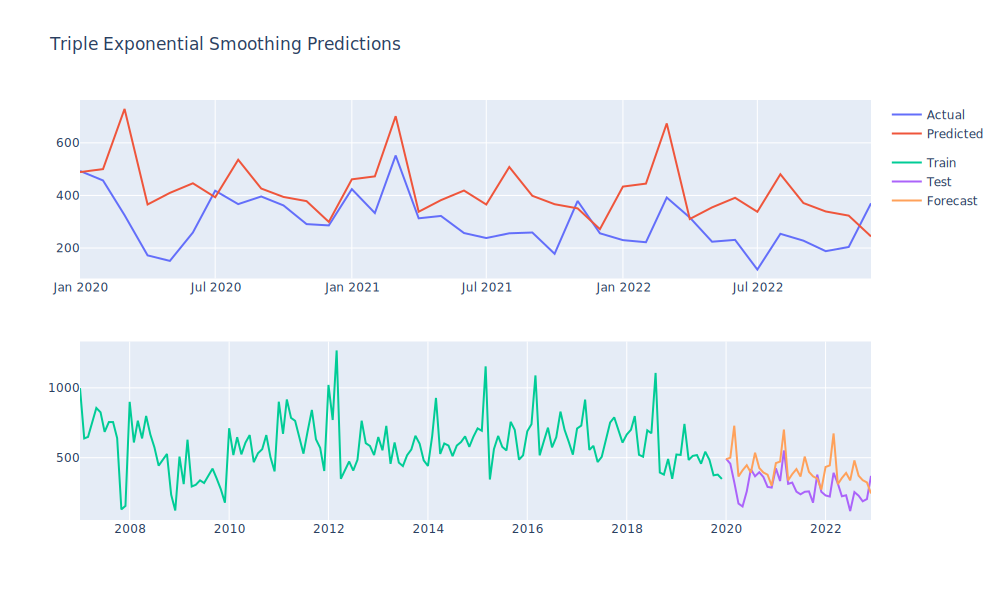

In [9]:
model_name='Triple Exponential Smoothing'

# Train
model = ExponentialSmoothing(train[dep_var],trend='add',seasonal='add',seasonal_periods=12).fit()

# Predict
predictions = model.predict(start=start, end=end)

# Forecast accuracy
forecast_accuracy(model_name, test[dep_var], predictions, True, True)

In [10]:
metrics

,Simple Exponential Smoothing,Double Exponential Smoothing,Triple Exponential Smoothing
Mean Absolute Error,173.865591,72.766465,132.316706
Mean Squared Error,37634.810537,9065.482986,26097.980209
Root Mean Squared Error,193.996934,95.212830,161.548693
R^2,-2.930715,0.053168,-1.725767
Mean Absolute Percentage Error,76.334523,30.412752,55.229885
Accuracy,23.665477,69.587248,44.770115


#### ARIMA

In [11]:
#Standard ARIMA Model
model = auto_arima(train[dep_var], 
                    start_p=1, 
                    start_q=1,
                    test='adf',                 # Use adftest to find optimal 'd'
                    max_p=3, max_q=3,           # Maximum p and q
                    m=1,                        # Frequency of series (if m==1, seasonal is set to FALSE automatically)
                    d=None,                     # Let model determine 'd'
                    seasonal=False,             # No Seasonality for standard ARIMA
                    trace=True,                 # Logs 
                    error_action= 'warn',       # Shows errors ('ignore' silences these)
                    suppress_warnings=True,
                    stepwise=True)                    

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2075.640, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2452.997, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2133.177, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2333.873, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2076.177, Time=0.13 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2076.309, Time=0.14 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2258.739, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2104.859, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2072.232, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2074.874, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2071.403, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2082.761, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=2070.533, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : 

In [12]:
#model.plot_diagnostics(figsize=(15,12))
#plt.show()

In [13]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  156
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -1031.266
Date:                Tue, 14 Feb 2023   AIC                           2070.533
Time:                        10:55:16   BIC                           2082.732
Sample:                    01-01-2007   HQIC                          2075.488
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    361.7350     45.367      7.973      0.000     272.816     450.654
ar.L1          0.2541      0.062      4.083      0.000       0.132       0.376
ar.L2          0.1382      0.077      1.798      0.072      -0.012       0.289
sigma2      3.172e+04   2962.114     10.708      0.000    2.59e+04    3.75e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                15.52
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                             0.46
Prob(H) (two-sided):                  0.15   Kurtosis:                         4.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

ARIMA Model Performance:
Mean Absolute Error: 291.65.
Mean Squared Error: 96366.49.
Root Mean Squared Error: 310.43.
R^2 Score = -9.06.
Mean Absolute Percentage Error: 122.50%.
Accuracy = -22.50%.


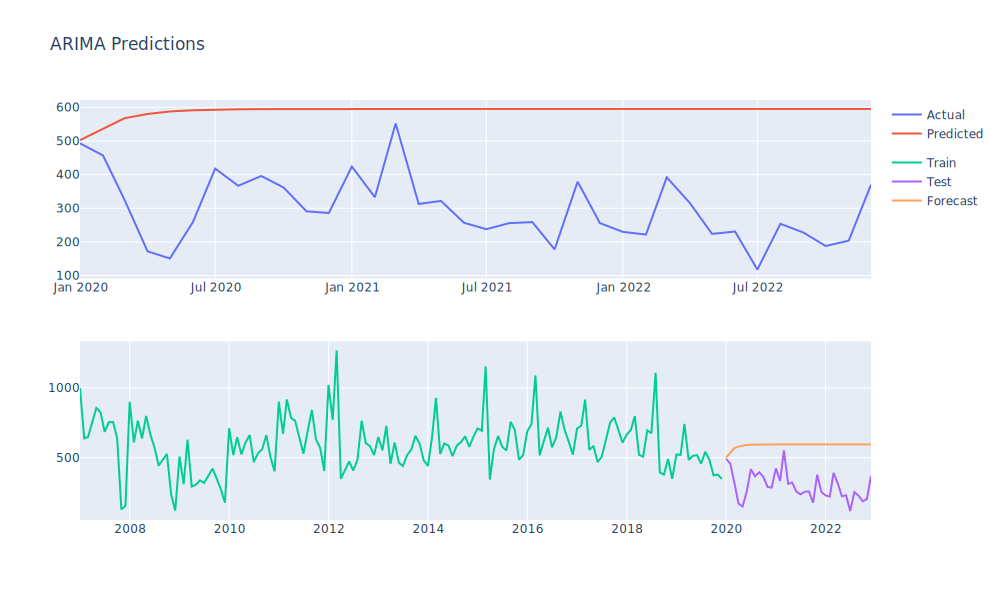

In [14]:
model_name='ARIMA'

# Predict
predictions = model.predict(n_periods=test.shape[0], dynamic=False, typ='levels')

# Forecast accuracy
forecast_accuracy(model_name, test[dep_var], predictions, True, True)

In [15]:
metrics

,Simple Exponential Smoothing,Double Exponential Smoothing,Triple Exponential Smoothing,ARIMA
Mean Absolute Error,173.865591,72.766465,132.316706,291.650604
Mean Squared Error,37634.810537,9065.482986,26097.980209,96366.486149
Root Mean Squared Error,193.996934,95.212830,161.548693,310.429519
R^2,-2.930715,0.053168,-1.725767,-9.064863
Mean Absolute Percentage Error,76.334523,30.412752,55.229885,122.496953
Accuracy,23.665477,69.587248,44.770115,-22.496953


#### SARIMA

In [16]:
# Seasonal - fit stepwise auto-ARIMA
model = auto_arima(train[dep_var],
                    start_p=1, 
                    start_q=1,
                    test='adf',                 # Use adftest to find optimal 'd'
                    max_p=3, max_q=3,           # Maximum p and q
                    m=12,                       # Frequency of series (if m==1, seasonal is set to FALSE automatically) - 12 months
                    start_P=0, 
                    seasonal=True,              # set to seasonal
                    d=None,                     # Let model determine 'd'
                    D=1,                        # Order of the seasonal differencing
                    trace=True,                 # Logs 
                    error_action='warn',        # Shows errors ('ignore' silences these)
                    suppress_warnings=True, 
                    stepwise=True)  

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1837.841, Time=0.48 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1911.136, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1872.008, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1839.863, Time=0.31 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1872.841, Time=0.13 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1839.746, Time=0.72 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1839.638, Time=1.16 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1852.309, Time=0.36 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=2.57 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1859.431, Time=0.25 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1839.650, Time=0.75 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=1839.702, Time=0.59 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1876.070, Time=0.29 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1837.738, Time=0.62 sec
 ARIMA(0,1,2)(0,1,0)[12]

In [17]:
#model.plot_diagnostics(figsize=(15,12))
#plt.show()

In [18]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  156
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -914.869
Date:                              Tue, 14 Feb 2023   AIC                           1837.738
Time:                                      10:55:33   BIC                           1849.589
Sample:                                  01-01-2007   HQIC                          1842.553
                                       - 12-01-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5723      0.060     -9.572      0.000      -0.689      -0.455
ma.L2         -0.1611      0.075     -2.134      0.033      -0.309      -0.013
ma.S.L12      -0.5935      0.091     -6.524      0.000      -0.772      -0.415
sigma2      2.033e+04   1887.117     10.774      0.000    1.66e+04     2.4e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               102.81
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                            -1.03
Prob(H) (two-sided):                  0.45   Kurtosis:                         6.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMA Model Performance:
Mean Absolute Error: 98.73.
Mean Squared Error: 16452.16.
Root Mean Squared Error: 128.27.
R^2 Score = -0.72.
Mean Absolute Percentage Error: 39.77%.
Accuracy = 60.23%.


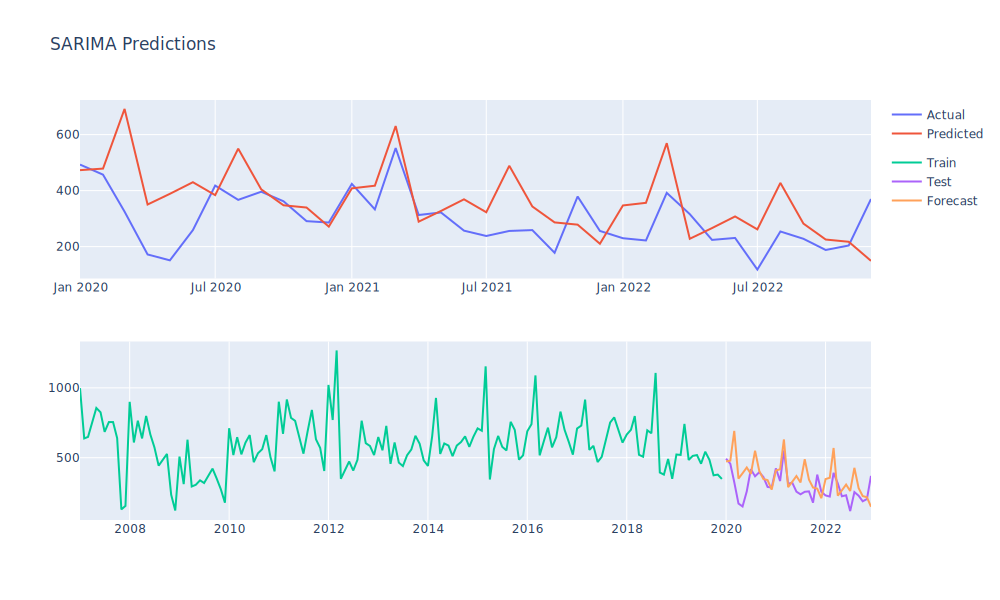

In [19]:
model_name='SARIMA'

# Predict
predictions = model.predict(n_periods=test.shape[0], dynamic=False, typ='levels')

# Forecast accuracy
forecast_accuracy(model_name, test[dep_var], predictions, True, True)

In [20]:
metrics

,Simple Exponential Smoothing,Double Exponential Smoothing,Triple Exponential Smoothing,ARIMA,SARIMA
Mean Absolute Error,173.865591,72.766465,132.316706,291.650604,98.725981
Mean Squared Error,37634.810537,9065.482986,26097.980209,96366.486149,16452.164339
Root Mean Squared Error,193.996934,95.212830,161.548693,310.429519,128.265991
R^2,-2.930715,0.053168,-1.725767,-9.064863,-0.718323
Mean Absolute Percentage Error,76.334523,30.412752,55.229885,122.496953,39.772932
Accuracy,23.665477,69.587248,44.770115,-22.496953,60.227068


#### SARIMAX

In [21]:
# SARIMAX = SARIMA with exogenous variable
exo_var = 'TIV'
model = auto_arima(train[dep_var], exogenous=train[[exo_var]],
                           start_p=1, 
                           start_q=1,
                           test='adf',
                           max_p=3, max_q=3, 
                           m=12,
                           start_P=0, 
                           seasonal=True,
                           d=None, 
                           D=1, 
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1837.841, Time=0.47 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1911.136, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1872.008, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1839.863, Time=0.32 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1872.841, Time=0.13 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=1839.746, Time=0.66 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=1839.638, Time=1.16 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=1852.309, Time=0.34 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=2.54 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=1859.431, Time=0.25 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1839.650, Time=0.77 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=1839.702, Time=0.55 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=1876.070, Time=0.18 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=1837.738, Time=0.52 sec
 ARIMA(0,1,2)(0,1,0)[12]

In [22]:
#model.plot_diagnostics(figsize=(15,12))
#plt.show()

In [23]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  156
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -914.869
Date:                              Tue, 14 Feb 2023   AIC                           1837.738
Time:                                      10:55:50   BIC                           1849.589
Sample:                                  01-01-2007   HQIC                          1842.553
                                       - 12-01-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5723      0.060     -9.572      0.000      -0.689      -0.455
ma.L2         -0.1611      0.075     -2.134      0.033      -0.309      -0.013
ma.S.L12      -0.5935      0.091     -6.524      0.000      -0.772      -0.415
sigma2      2.033e+04   1887.117     10.774      0.000    1.66e+04     2.4e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               102.81
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                            -1.03
Prob(H) (two-sided):                  0.45   Kurtosis:                         6.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\ne74255\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



SARIMAX Model Performance:
Mean Absolute Error: 73.80.
Mean Squared Error: 10086.37.
Root Mean Squared Error: 100.43.
R^2 Score = -0.05.
Mean Absolute Percentage Error: 24.43%.
Accuracy = 75.57%.


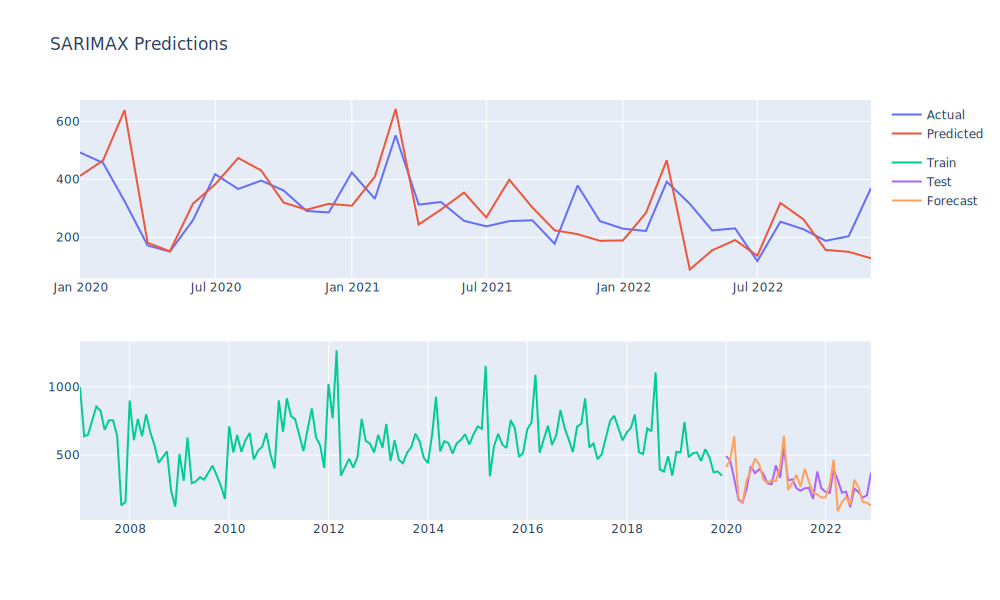

In [24]:
model_name='SARIMAX'

# Build model
model = sm.tsa.statespace.SARIMAX(train[dep_var],order=(0,1,2),seasonal_order=(0,1,1,12),exog = train[exo_var]).fit()

# Predict
predictions = model.predict(start=start, end=end, exog = test[exo_var],  dynamic=False, typ='levels')

# Forecast accuracy
forecast_accuracy(model_name, test[dep_var], predictions, True, True)

### Summary

In [25]:
metrics

,Simple Exponential Smoothing,Double Exponential Smoothing,Triple Exponential Smoothing,ARIMA,SARIMA,SARIMAX
Mean Absolute Error,173.865591,72.766465,132.316706,291.650604,98.725981,73.803921
Mean Squared Error,37634.810537,9065.482986,26097.980209,96366.486149,16452.164339,10086.369374
Root Mean Squared Error,193.996934,95.212830,161.548693,310.429519,128.265991,100.430918
R^2,-2.930715,0.053168,-1.725767,-9.064863,-0.718323,-0.053457
Mean Absolute Percentage Error,76.334523,30.412752,55.229885,122.496953,39.772932,24.429002
Accuracy,23.665477,69.587248,44.770115,-22.496953,60.227068,75.570998


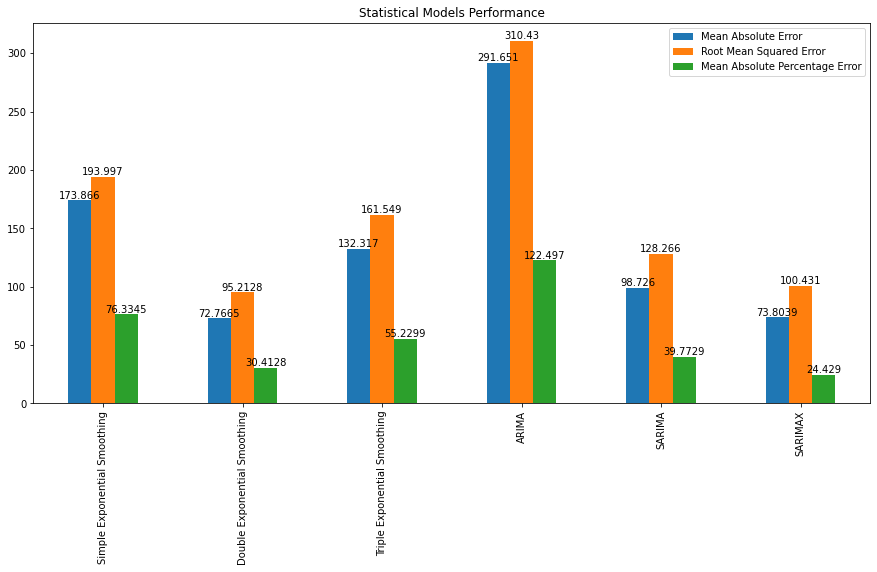

In [26]:
chart = metrics.transpose()
chart.drop(['Mean Squared Error', 'R^2', 'Accuracy'], axis=1, inplace=True)

ax = chart.plot.bar(title="Statistical Models Performance", figsize=(15,7))
for container in ax.containers:
    ax.bar_label(container)